In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, csr_matrix
import networkx as nx
from numba import jit
from itertools import product
from multiprocessing import Pool

import matplotlib.pyplot as plt

## Test performance influence expantion

In [2]:
p = 0.4
N = 100

In [31]:
matrices = np.random.binomial(1, p, (3, N, N))
for i in range(matrices.shape[0]):
    # fill diagonal with zeros in place
    np.fill_diagonal(matrices[i,:,:], 0)

G = [ nx.from_numpy_matrix(matrices[i,:,:], create_using=nx.DiGraph()) for i in range(matrices.shape[0]) ]
matrices = [ matrices[i, :, :] for i in range(matrices.shape[0]) ]

# load resistance values
res = np.load('FLTR-Gnp/data/res_phase1.npy')

In [23]:
G

In [12]:
matrices[0].shape

(100, 100)

In [96]:
def expand_influence(G, x, t, directed, n):
    '''
    This function computes the FLTR metric for the x node in the G graph.

    INPUT
    G : networkx Graph/DiGraph, G = (V,E)
    x : int, node of interest
    t : float, resistance values (constant on nodes)

    OUTPUT
    total : int, FLTR(x)
    max(exp_level): int, maximum expantion level reached during the computation
    '''

    # save nodes in an numpy array
    nodes = np.array(G.nodes)
    # convert the percentage in a number
    T = t * n
    # compute the activation set for the node of interest
    if directed: X = [y for y in G.predecessors(x)] + [x]
    else: X = [y for y in G.neighbors(x)] + [x]
    # initialize counter for the active nodes
    total = len(X)
    # list (queue) of active nodes
    Q = sorted(X)
    # node states (active = True, not active = False)
    state = np.array([v in X for v in nodes])
    # node incoming influence (starting from zero, at most n)
    influence = np.array([0] * n)
    # node expantion level (starting from 0 if in X, else -1. worst case: n)
    exp_level = np.array([-int(not v in X) for v in nodes])

    # vectorized version of the influence expantion
    while Q != []:
        # dequeue
        v = Q.pop(0)
        # define neighborhood mask
        if directed: neigh = np.isin(nodes, list(G.predecessors(v)))
        else: neigh = np.isin(nodes, list(G.neighbors(v)))
        # update expantion levels
        exp_level[~state & neigh] = exp_level[v] + 1
        # update influence values
        influence[~state & neigh] += 1
        # define activation mask
        activated = ~state & neigh & (influence > T)
        # update state values
        state[activated] = True
        # update counter of activated nodes
        total += sum(activated)
        # enqueue the activated nodes
        Q.extend(nodes[activated])

    return  total, max(exp_level)

In [97]:
# info
start_time = time.time()

nodes = np.arange(1000) # use all available nodes

# run in parallel the expantion on a fixed value of p_i and save the outputs
pool = Pool() # initialize the constructor
# associate processes to args
out = pd.DataFrame.from_records({'args' : list(product(range(3), nodes, res)) ,
                                 'output' : pool.starmap(expand_influence, product(G, nodes, res, [True], [1000]))
                                })
# output converted in a dataframe
raw_data = pd.DataFrame.from_records(out.apply(lambda x: [x.args[0],x.args[1],x.args[2],x.output[0],x.output[1]],axis=1),
                          columns= ['realization','node','resistance', 'metric','max_level'])
del out
raw_data.to_csv('data_{}_{}_{}.csv'.format('dir', 1000, 0.1))
# statistics per node (double index: resistance and node)
data_per_node = raw_data.groupby('resistance').apply(lambda x: x[['metric','max_level','node']].groupby('node').mean())
data_per_node.to_csv('data_node_{}_{}_{}.csv'.format('dir', 1000, 0.1))
del data_per_node
# statistics per graph G(n,p,t) (single index: resistance)
data_per_prob = raw_data.groupby('resistance').mean()[['metric', 'max_level']]
data_per_prob.to_csv('data_graph_{}_{}_{}.csv'.format('dir', 1000, 0.1))
del data_per_prob
del raw_data
# close the constructor
pool.close()

# info
end_time = time.time()
uptime = end_time - start_time
human_uptime = datetime.timedelta(seconds=uptime)
print("Total uptime: {} \n".format(human_uptime))

Process ForkPoolWorker-267:
Process ForkPoolWorker-264:
Process ForkPoolWorker-265:
Process ForkPoolWorker-266:

KeyboardInterrupt



In [15]:
data_node = pd.read_csv('data_node_{}_{}_{}.csv'.format('dir', 1000, 0.1))
data_node[data_node.resistance == 0.25]

,resistance,node,metric,max_level
0,0.25,0,9.000000,1.0
1,0.25,1,11.000000,1.0
2,0.25,2,9.333333,1.0
3,0.25,3,10.666667,1.0
4,0.25,4,15.666667,1.0
...,...,...,...,...
995,0.25,995,10.666667,1.0
996,0.25,996,12.333333,1.0
997,0.25,997,10.666667,1.0
998,0.25,998,10.333333,1.0


In [32]:
@jit(nopython=True)
def FLTM(t, Q, exp_level, influence, state, total, nodes, pred, n, G):
    # vectorized version of the influence expantion
    for i in range(n):
        neigh = np.array([False]*n)
        # dequeue
        v = Q[0]
        Q = Q[1:]
        # define neighborhood mask
        for j in list(np.nonzero(G[v,:])[0]):
            neigh[j] = True
        # update expantion levels
        exp_level[~state & neigh] = exp_level[v] + 1
        # update influence values
        influence[~state & neigh] += 1
        # define activation mask
        activated = ~state & neigh & (influence > pred * t)
        # update state values
        state[activated] = True
        # update counter of activated nodes
        total += np.sum(activated)
        # enqueue the activated nodes
        act = nodes[activated]
        Q = np.concatenate((Q, act))
        if Q.size == 0:
            break

    return  total, max(exp_level), np.mean(exp_level)


def expand_influence_np(n_job, args):
    '''
    This function computes the FLTR metric for the x node in the G graph.

    INPUT
    G : numpy, adjacency matrix of a graph (n x n). i -> j iff A{i,j} = 1
    x : int, node of interest
    t : float, resistance values (constant on nodes)
    n : int, graph size

    OUTPUT
    total : int, FLTR(x)
    max(exp_level): int, maximum expantion level reached during the computation
    mean(exp_level): int, mean expantion level reached during the computation
    '''
    
    G, x, t, n, jobs = args
    
    # info
    print('Jobs {}/{}'.format(int(n_job), int(jobs)))
    # save nodes in an numpy array
    nodes = np.arange(n)
    # compute the activation set for the node of interest
    X = list(np.nonzero(G[x,:])[0]) + [x]
    # initialize counter for the active nodes
    total = len(X)
    # list (queue) of active nodes
    Q = np.array(sorted(X))
    # node states (active = True, not active = False)
    state = np.array([v in X for v in nodes])
    # node incoming influence (starting from zero, at most n)
    influence = np.array([0] * n)
    # node expantion level (starting from 0 if in X, else -1. worst case: n)
    exp_level = np.array([-int(not v in X) for v in nodes])
        # number of predecessors for each node
    pred = np.array([len(np.nonzero(G[:,v])[0]) for v in nodes])
    
    return FLTM(t, Q, exp_level, influence, state, total, nodes, pred, n, G)

In [33]:
# info
start_time = time.time()

nodes = np.arange(N) # use all available nodes

# run in parallel the expantion on a fixed value of p_i and save the outputs
pool = Pool() # initialize the constructor
# compute number of jobs
n_jobs = 3 * len(nodes) * len(res)
# associate processes to args
out = pd.DataFrame.from_records({'args' : list(product(range(3), nodes, res)) ,
                                 'output' : pool.starmap(expand_influence_np, enumerate(product(matrices, nodes, res, [N], [n_jobs])) ) 
                                })
# output converted in a dataframe
raw_data = pd.DataFrame.from_records(out.apply(lambda x: [x.args[0],x.args[1],x.args[2],x.output[0],x.output[1],x.output[2]],axis=1),
                          columns= ['realization', 'node', 'resistance', 'metric', 'max_level', 'avg_level'])
del out
raw_data.to_csv('data_{}_{}_{}.csv'.format('dir', N, p))
# statistics per node (double index: resistance and node)
data_per_node = raw_data.groupby('resistance').apply(lambda x: x[['metric', 'max_level', 'avg_level', 'node']].groupby('node').mean())
data_per_node.to_csv('data_node_{}_{}_{}.csv'.format('dir', N, p))
del data_per_node
# statistics per graph G(n,p,t) (single index: resistance)
data_per_prob = raw_data.groupby('resistance').mean()[['metric', 'max_level', 'avg_level']]
data_per_prob.to_csv('data_graph_{}_{}_{}.csv'.format('dir', N, p))
del data_per_prob
del raw_data
# close the constructor
pool.close()

# info
end_time = time.time()
uptime = end_time - start_time
human_uptime = datetime.timedelta(seconds=uptime)
print("Size: {} \n Total uptime: {} \n".format(N, human_uptime))

Jobs 0/1200
Jobs 225/1200
Jobs 150/1200
Jobs 75/1200
Jobs 1/1200
Jobs 76/1200
Jobs 2/1200
Jobs 3/1200
Jobs 226/1200
Jobs 227/1200
Jobs 228/1200
Jobs 77/1200
Jobs 229/1200
Jobs 4/1200
Jobs 78/1200
Jobs 230/1200
Jobs 79/1200
Jobs 231/1200
Jobs 80/1200
Jobs 5/1200
Jobs 81/1200
Jobs 232/1200
Jobs 82/1200
Jobs 6/1200
Jobs 83/1200
Jobs 7/1200
Jobs 84/1200
Jobs 8/1200
Jobs 85/1200
Jobs 233/1200
Jobs 234/1200
Jobs 235/1200
Jobs 86/1200
Jobs 9/1200
Jobs 236/1200
Jobs 237/1200
Jobs 87/1200
Jobs 238/1200
Jobs 239/1200
Jobs 10/1200
Jobs 151/1200
Jobs 152/1200
Jobs 240/1200
Jobs 88/1200
Jobs 11/1200
Jobs 12/1200
Jobs 89/1200
Jobs 153/1200
Jobs 241/1200
Jobs 90/1200
Jobs 242/1200
Jobs 13/1200
Jobs 243/1200
Jobs 14/1200
Jobs 154/1200
Jobs 155/1200
Jobs 91/1200
Jobs 15/1200
Jobs 156/1200
Jobs 244/1200
Jobs 92/1200
Jobs 93/1200
Jobs 157/1200
Jobs 245/1200
Jobs 94/1200
Jobs 158/1200
Jobs 95/1200
Jobs 16/1200
Jobs 17/1200
Jobs 96/1200
Jobs 159/1200
Jobs 246/1200
Jobs 97/1200
Jobs 160/1200
Jobs 18/1200
Jo

Jobs 607/1200
Jobs 449/1200
Jobs 585/1200
Jobs 586/1200
Jobs 608/1200
Jobs 678/1200
Jobs 587/1200
Jobs 609/1200
Jobs 750/1200
Jobs 588/1200
Jobs 610/1200
Jobs 751/1200
Jobs 752/1200
Jobs 589/1200
Jobs 611/1200
Jobs 753/1200
Jobs 754/1200
Jobs 679/1200
Jobs 590/1200
Jobs 612/1200
Jobs 755/1200
Jobs 680/1200
Jobs 613/1200
Jobs 591/1200
Jobs 756/1200
Jobs 681/1200
Jobs 592/1200
Jobs 682/1200
Jobs 757/1200
Jobs 614/1200
Jobs 758/1200
Jobs 593/1200
Jobs 683/1200
Jobs 594/1200
Jobs 615/1200
Jobs 759/1200
Jobs 684/1200
Jobs 616/1200
Jobs 760/1200
Jobs 761/1200
Jobs 595/1200
Jobs 596/1200
Jobs 685/1200
Jobs 617/1200
Jobs 686/1200
Jobs 597/1200
Jobs 598/1200
Jobs 687/1200
Jobs 688/1200
Jobs 618/1200
Jobs 599/1200
Jobs 762/1200
Jobs 689/1200
Jobs 690/1200
Jobs 619/1200
Jobs 825/1200
Jobs 620/1200
Jobs 763/1200
Jobs 691/1200
Jobs 764/1200
Jobs 826/1200
Jobs 621/1200
Jobs 692/1200
Jobs 827/1200
Jobs 765/1200
Jobs 622/1200
Jobs 623/1200
Jobs 624/1200
Jobs 828/1200
Jobs 766/1200
Jobs 693/1200
Jobs 6

Jobs 973/1200
Jobs 1114/1200
Jobs 974/1200
Jobs 1186/1200
Jobs 1045/1200
Jobs 1046/1200
Jobs 1187/1200
Jobs 1188/1200
Jobs 1115/1200
Jobs 1189/1200
Jobs 1116/1200
Jobs 1190/1200
Jobs 1047/1200
Jobs 1191/1200
Jobs 1117/1200
Jobs 1192/1200
Jobs 1118/1200
Jobs 1048/1200
Jobs 1049/1200
Jobs 1119/1200
Jobs 1193/1200
Jobs 1120/1200
Jobs 1194/1200
Jobs 1121/1200
Jobs 1195/1200
Jobs 1122/1200
Jobs 1123/1200
Jobs 1196/1200
Jobs 1197/1200
Jobs 1198/1200
Jobs 1199/1200
Jobs 1124/1200
Size: 100 
 Total uptime: 0:00:05.885916 



In [15]:
def expand_influence_sparse(G, x, t, n):
    '''
    This function computes the FLTR metric for the x node in the G graph.

    INPUT
    G : numpy, adjacency matrix of a graph (n x n). i -> j iff A{i,j} = 1
    x : int, node of interest
    t : float, resistance values (constant on nodes)
    n : int, graph size

    OUTPUT
    total : int, FLTR(x)
    max(exp_level): int, maximum expantion level reached during the computation
    mean(exp_level): int, mean expantion level reached during the computation
    '''

    # save nodes in an numpy array
    nodes = np.arange(n)
    # convert the percentage in a number
    T = t * (n - 1)
    # compute the activation set for the node of interest
    X = list(G[:,x].nonzero()[0]) + [x]
    # initialize counter for the active nodes
    total = len(X)
    # list (queue) of active nodes
    Q = sorted(X)
    # node states (active = True, not active = False)
    state = np.array([v in X for v in nodes])
    # node incoming influence (starting from zero, at most n)
    influence = np.array([0] * n)
    # node expantion level (starting from 0 if in X, else -1. worst case: n)
    exp_level = np.array([-int(not v in X) for v in nodes])

    # vectorized version of the influence expantion
    while Q != []:
        # dequeue
        v = Q.pop(0)
        # define neighborhood mask
        neigh = np.isin(nodes, list(G[:,v].nonzero()[0]))
        # update expantion levels
        exp_level[~state & neigh] = exp_level[v] + 1
        # update influence values
        influence[~state & neigh] += 1
        # define activation mask
        activated = ~state & neigh & (influence > T)
        # update state values
        state[activated] = True
        # update counter of activated nodes
        total += sum(activated)
        # enqueue the activated nodes
        Q.extend(nodes[activated])

    return  total, max(exp_level), np.mean(exp_level)

In [16]:
# info
start_time = time.time()

matrices = [ csc_matrix(matrices[i]) for i in range(len(matrices)) ]

# run in parallel the expantion on a fixed value of p_i and save the outputs
pool = Pool() # initialize the constructor
# associate processes to args
out = pd.DataFrame.from_records({'args' : list(product(range(3), nodes, res)) ,
                                 'output' : pool.starmap(expand_influence_sparse, product(matrices, nodes, res, [100]))
                                })
# output converted in a dataframe
raw_data = pd.DataFrame.from_records(out.apply(lambda x: [x.args[0],x.args[1],x.args[2],x.output[0],x.output[1],x.output[2]],axis=1),
                          columns= ['realization', 'node', 'resistance', 'metric', 'max_level', 'avg_level'])
del out
raw_data.to_csv('data_{}_{}_{}.csv'.format('dir', 100, 0.1))
# statistics per node (double index: resistance and node)
data_per_node = raw_data.groupby('resistance').apply(lambda x: x[['metric', 'max_level', 'avg_level', 'node']].groupby('node').mean())
data_per_node.to_csv('data_node_{}_{}_{}.csv'.format('dir', 100, 0.1))
del data_per_node
# statistics per graph G(n,p,t) (single index: resistance)
data_per_prob = raw_data.groupby('resistance').mean()[['metric', 'max_level', 'avg_level']]
data_per_prob.to_csv('data_graph_{}_{}_{}.csv'.format('dir', 100, 0.1))
del data_per_prob
del raw_data
# close the constructor
pool.close()

# info
end_time = time.time()
uptime = end_time - start_time
human_uptime = datetime.timedelta(seconds=uptime)
print("Size: {} \n Total uptime: {} \n".format(100, human_uptime))

Size: 100 
 Total uptime: 0:00:03.752695 



## Test plots

In [105]:
def plot_p1(prob, directed, n, res, t):
    # check the directed value
    if directed:
        lab = 'dir'
    else : lab = 'und'
    # check the t type
    #if t:
    #    thr = 'maxpred'
    #else : thr = 'pred'
    
    
    fig, axs = plt.subplots(len(res), 1, figsize = (10,20))
    for i, t in enumerate(res):
        data = {}
        for p in prob:
            # load data
            temp = pd.read_csv('data_node_{}_{}_{}.csv'.format(lab, n, p))
            data[p] = bool(sum(temp[temp.resistance == t].max_level < 1))
            del temp
        
        # plot data
        axs[i].set_title('Phase transition for t = {}'.format(t), fontsize=15)
        _ = axs[i].plot(list(data.keys()), list(data.values()), 'o-')
        #_ = axs[i].set_xlim(xmax=0.2)

        # delete from memory
        del data

    plt.suptitle('Phase transition for maxlevel < 1, n = {}, {}'.format(n, lab), y=1.01, fontsize=20)
    plt.tight_layout()
    #plt.savefig('images/stats_per_node_{}_{}_{}.jpeg'.format(thr, lab, n))

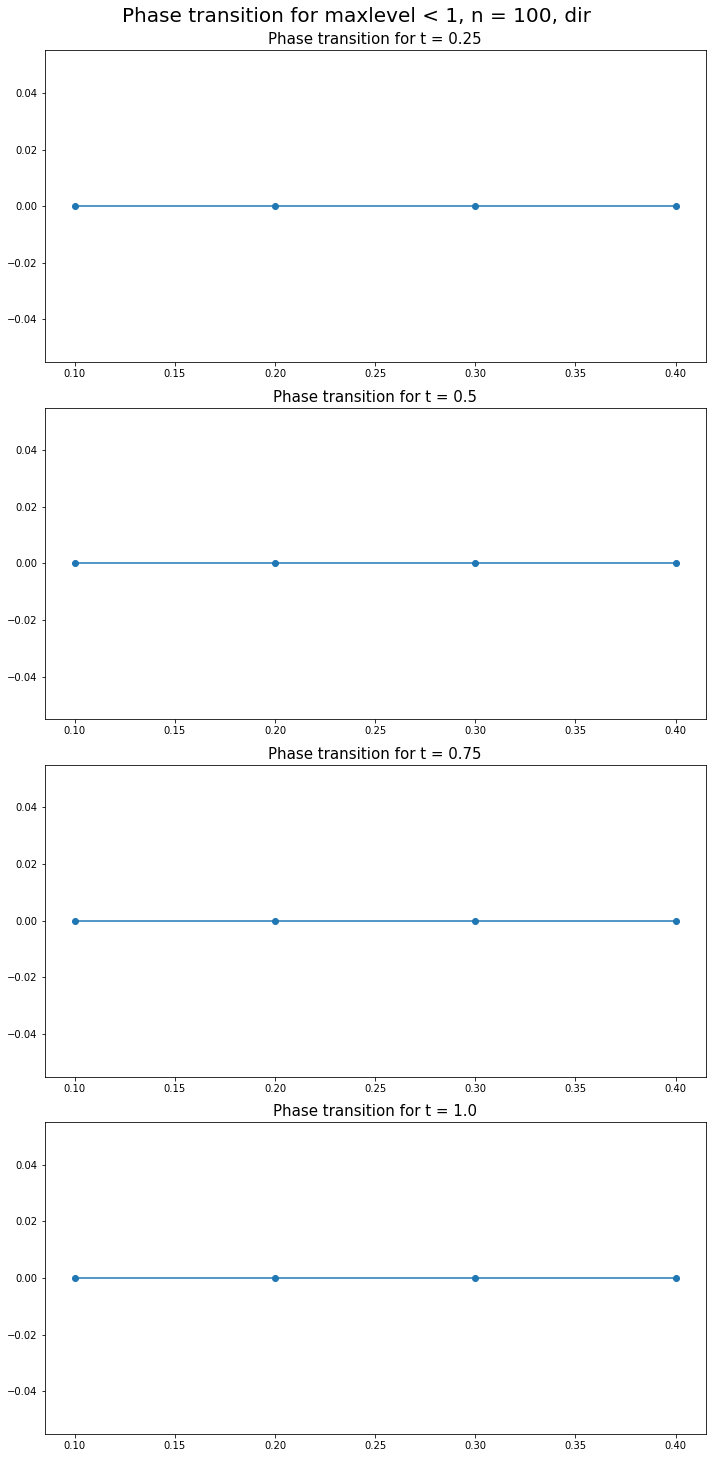

In [108]:
# load resistance values
res = np.load('FLTR-Gnp/data/res_phase1.npy')
p = [0.1, 0.2, 0.3, 0.4]
N = 100

plot_p1(p, True, N, res, True)

## More precisee representation


In [ ]:
# read raw data
data = pd.read_csv('data_dir_100_0.2.csv', index_col=0)
# on each realization check for which nodes the property is realized
p1 = data[data.resistance == 0.25].groupby('realization').apply(lambda x: x.max_level > 1)
data.head()

In [92]:
p1

realization      
0            0       True
             4       True
             8       True
             12      True
             16      True
                     ... 
2            1180    True
             1184    True
             1188    True
             1192    True
             1196    True
Name: max_level, Length: 300, dtype: bool

In [93]:
# for each realization, check if exist a node that realizes + compute a mean value of "truth"
p2 = (pd.DataFrame(p1).groupby('realization').sum(axis=0) > 0).mean() 
p2

max_level    1.0
dtype: float64

In [101]:
def plot_p1(prob, directed, n, res, t):
    # check the directed value
    if directed:
        lab = 'dir'
    else : lab = 'und'
    # check the t type
    #if t:
    #    thr = 'maxpred'
    #else : thr = 'pred'
    
    
    fig, axs = plt.subplots(len(res), 1, figsize = (10,20))
    for i, t in enumerate(res):
        data = {}
        for p in prob:
            # load data
            temp = pd.read_csv('data_{}_{}_{}.csv'.format(lab, n, p), index_col=0)
            # on each realization check for which nodes the property is realized
            temp2 = temp[temp.resistance == t].groupby('realization').apply(lambda x: x.max_level > 1)
            data[p] = (pd.DataFrame(temp2).groupby('realization').sum(axis=0) > 0).mean() 
            del temp, temp2
        
        # plot data
        axs[i].set_title('Phase transition for t = {}'.format(t), fontsize=15)
        _ = axs[i].plot(list(data.keys()), list(data.values()), 'o-')
        #_ = axs[i].set_xlim(xmax=0.2)

        # delete from memory
        del data

    plt.suptitle('Phase transition for maxlevel < 1, n = {}, {}'.format(n, lab), y=1.01, fontsize=20)
    plt.tight_layout()
    #plt.savefig('images/stats_per_node_{}_{}_{}.jpeg'.format(thr, lab, n))

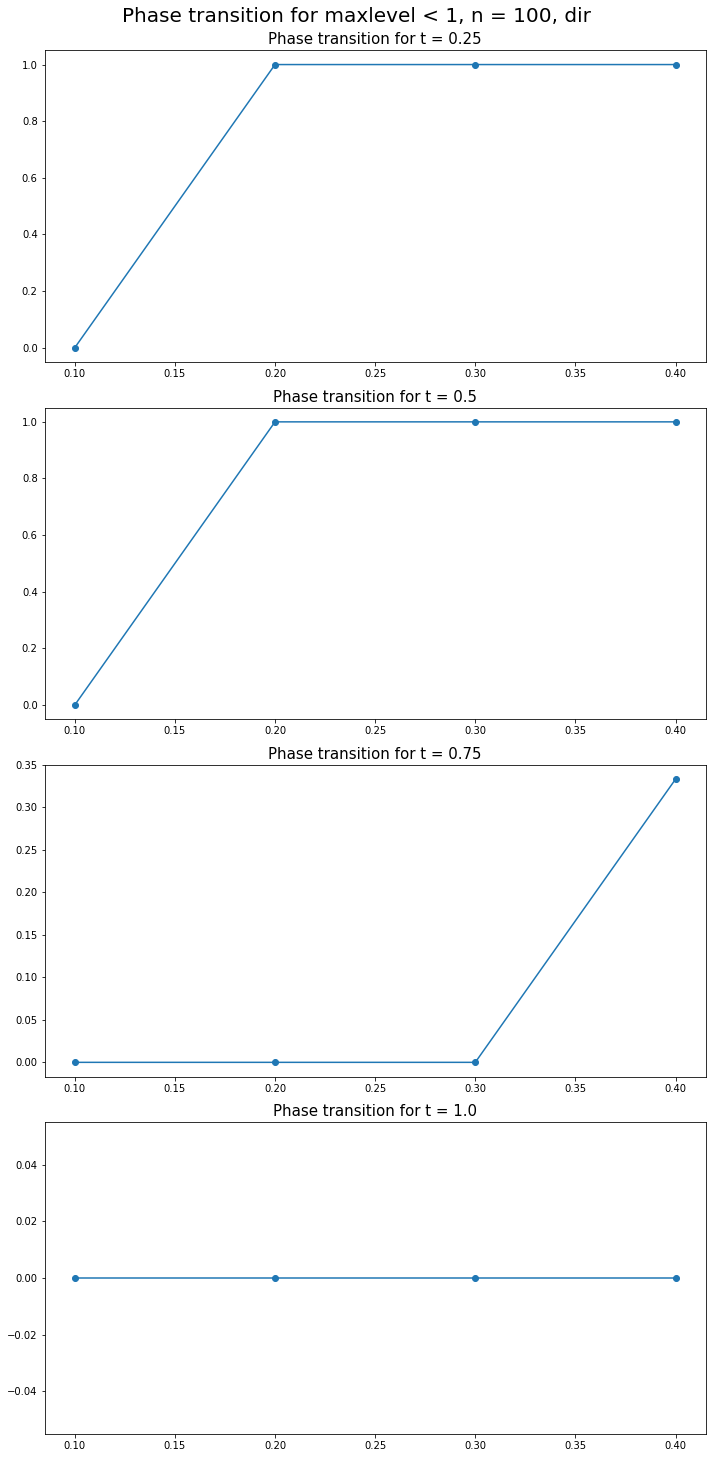

In [102]:
plot_p1(p, True, N, res, True)

{0.25: 0.0}
{0.25: 0.0, 0.5: 0.0}
{0.25: 0.0, 0.5: 0.0, 0.75: 0.0}
{0.25: 0.0, 0.5: 0.0, 0.75: 0.0, 1.0: 0.0}
{0.25: 1.0}
{0.25: 1.0, 0.5: 1.0}
{0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
{0.25: 1.0, 0.5: 1.0, 0.75: 0.0, 1.0: 0.0}
{0.25: 1.0}
{0.25: 1.0, 0.5: 1.0}
{0.25: 1.0, 0.5: 1.0, 0.75: 0.0}
{0.25: 1.0, 0.5: 1.0, 0.75: 0.0, 1.0: 0.0}
{0.25: 1.0}
{0.25: 1.0, 0.5: 1.0}
{0.25: 1.0, 0.5: 1.0, 0.75: 0.3333333333333333}
{0.25: 1.0, 0.5: 1.0, 0.75: 0.3333333333333333, 1.0: 0.0}


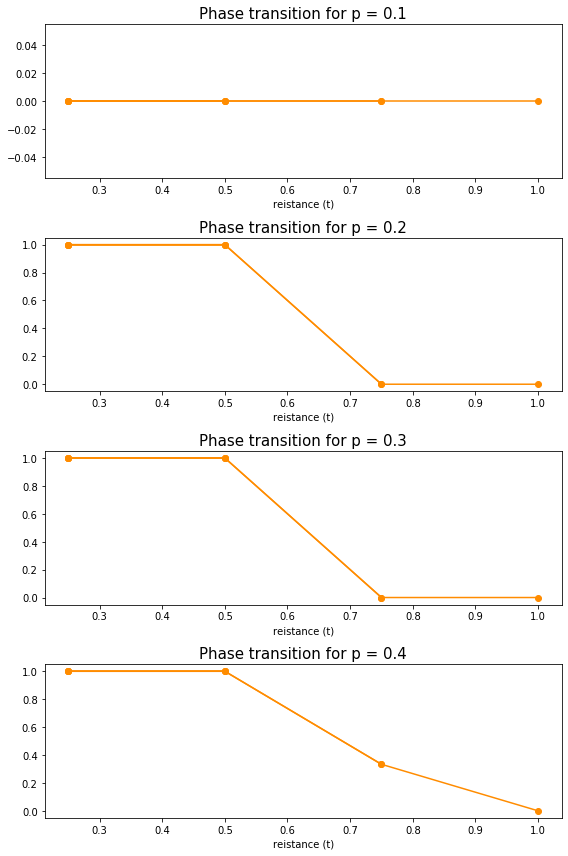

In [24]:
# load resistance values
res = np.load('FLTR-Gnp/data/res_phase1.npy')
prob = [0.1, 0.2, 0.3, 0.4]

fig, axs = plt.subplots(len(res), 1, figsize = (8,12))
for i, p in enumerate(prob):
    temp = pd.read_csv('data_dir_{}_{}.csv'.format(100, p), index_col=0)
    data = {}
    for t in res:
        temp2 = temp[temp.resistance == t].groupby('realization').apply(lambda x: (x.max_level > 1))
        data[t] = (pd.DataFrame(temp2).groupby('realization').sum() > 0).mean().values.item()
        print(data)
        del temp2
        
        # plot data
        axs[i].set_title('Phase transition for p = {}'.format(p), fontsize=15)
        _ = axs[i].plot(list(data.keys()), list(data.values()), 'o-', color='darkorange')
        #_ = axs[i].set_xlim(xmax=0.2)
        _ = axs[i].set_xlabel('reistance (t)')
    del temp
    
del data

#plt.suptitle('Phase transition for maxlevel < 1, n = {}, {}'.format(n, lab), y=1.02, fontsize=20)
plt.tight_layout()
#plt.savefig('images/p0_{}_{}_{}.jpeg'.format(thr, lab, n))

In [15]:
temp = pd.read_csv('data_dir_{}_{}.csv'.format(100, p), index_col=0)

In [16]:
temp.head()

,realization,node,resistance,metric,max_level,avg_level
0,0,0,0.25,100,2,0.60
1,0,0,0.50,100,4,2.04
2,0,0,0.75,41,1,0.59
3,0,0,1.00,41,1,0.59
4,0,1,0.25,100,1,0.63


In [17]:
temp2 = temp.groupby('realization').apply(lambda x: (x.max_level > 1))
temp2.head()

realization   
0            0     True
             1     True
             2    False
             3    False
             4    False
Name: max_level, dtype: bool

In [14]:
temp3 = (pd.DataFrame(temp2).groupby('realization').sum() > 0).mean() 
temp3.head()

max_level    1.0
dtype: float64